# Constants

In [1]:
DATASET_PATH = '../data/dataset_final.csv'
DIAGNOSIS_CODES_PATH = '../data/diagnosis_codes_final.csv'

# Imports

In [2]:
import pandas as pd
import numpy as np
import json
import random
import matplotlib.pyplot as plt
from collections import defaultdict

# Distribution

In [3]:
# Read as raw lines instead of structured CSV
with open(DATASET_PATH) as f:
    records = [line.strip().split(",") for line in f if line.strip()]

# Now 'records' is a list of lists
print("Total records:", len(records))
print("Example record:", records[0])

Total records: 58302
Example record: ['378.6', '385.02', '094.84', 'V45.69', '952.01', '782.4', '726.2', 'E82.8']


In [4]:
# Convert to DataFrame for compatibility, but note that lengths vary
df_dataset = pd.DataFrame({'codes': records})

# Each row of df_dataset['codes'] is a list of codes
df_dataset.shape

(58302, 1)

In [6]:
code_counts = df_dataset['codes'].apply(len)

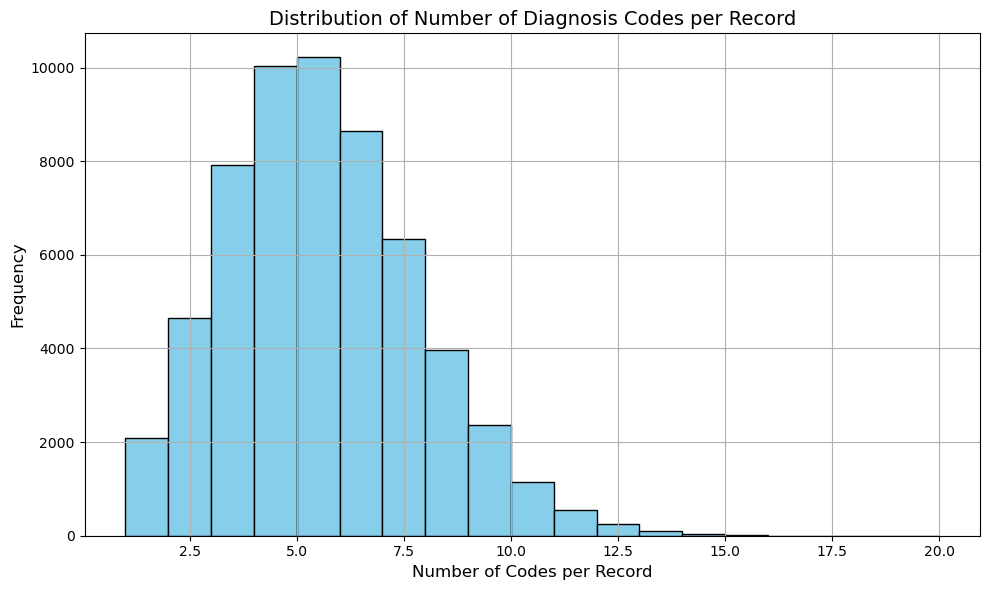

In [7]:
plt.figure(figsize=(10, 6))
plt.hist(code_counts, bins=range(1, max(code_counts)+2), edgecolor='black', color='skyblue')
plt.title("Distribution of Number of Diagnosis Codes per Record", fontsize=14)
plt.xlabel("Number of Codes per Record", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

This histogram shows the distribution of the number of diagnosis codes per patient record in the synthetic dataset. The x-axis represents how many codes appear in a single record (e.g., 5 means that record has 5 diagnosis codes). The y-axis represents the number of records that contain that specific count of codes — i.e., the frequency.

For example:
- At x = 5, the bar height tells us that just under 10,000 records have exactly 5 diagnosis codes.
- At x = 1, about 2,000 records have only 1 code.

Very few records have more than 15 codes — matching the expected right-skewed shape of a Poisson-like distribution.

# Feasibility of identity disclosure

The primary goal of this section is to measure the re-identification risk of patient records based on diagnosis code combinations. The motivation is: If a certain combination of diagnosis codes appears only in one or a few records, that combination can potentially identify individuals uniquely.

So, this section answers: "How likely is it that someone could re-identify a patient based on m diagnosis codes?". The number of records that share a set of m diagnosis codes equals the inverse of the probability of performing identity disclosure, using these codes.

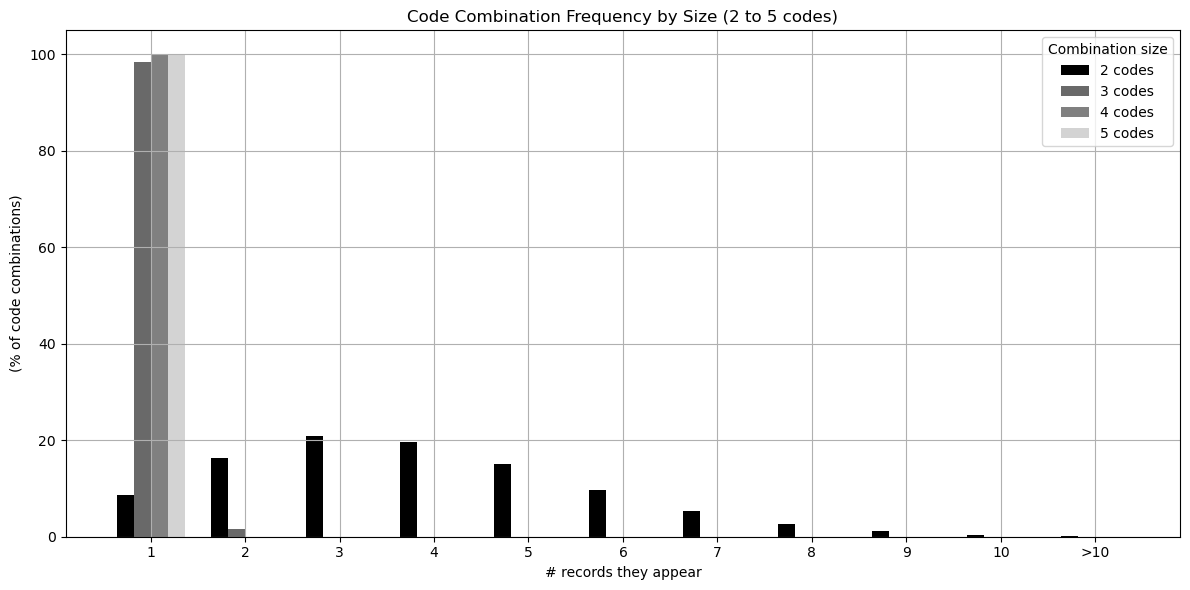

In [8]:
from itertools import combinations # module to generate combinations
# combinations(["A", "B", "C"], 2)
# → ("A", "B"), ("A", "C"), ("B", "C")
from collections import Counter # a dict-like object to count frequencies
# Counter(["x", "y", "x"])
# → Counter({'x': 2, 'y': 1})

# Convert each record (string) to a sorted list of diagnosis codes
records = df_dataset['codes'].apply(sorted).tolist()

# Setup plotting parameters
ms = [2, 3, 4, 5]  # combination sizes
colors = ['black', 'dimgray', 'gray', 'lightgray']  # one color per m
x_labels = [str(i) for i in range(1, 11)] + ['>10']
x_indices = np.arange(len(x_labels))  # for proper x-tick alignment
bar_width = 0.18  # width of each bar

# Prepare figure
plt.figure(figsize=(12, 6))
# Initialize a list to hold the summary table values
summary_data = []

# Loop over each m (size of combination)
for i, (m, color) in enumerate(zip(ms, colors)):
    # Counts how many times each m-combination appears in the whole dataset
    combo_counter = Counter()

    # Generate all m-sized code combinations across all records
    for codes in records:
        if len(codes) >= m:
            combo_counter.update(combinations(codes, m))

    # Count how often each combination appears (e.g., 1 time, 2 times, ...)
    freq_counter = Counter(combo_counter.values())

    # Normalize: Convert to percentage of total combinations
    total_combos = sum(freq_counter.values())
    y_vals = [0] * len(x_labels)
    for count, freq in freq_counter.items():
        if count <= 10:
            y_vals[count - 1] += 100 * freq / total_combos
        else:
            y_vals[-1] += 100 * freq / total_combos

    # Offset bars to group side-by-side for each x tick
    offset = (i - 1.5) * bar_width
    positions = x_indices + offset
    plt.bar(positions, y_vals, width=bar_width, color=color, label=f"{m} codes")

    # Prepare summary stats for table
    appear_once = freq_counter[1] / total_combos * 100
    appear_twice = freq_counter[2] / total_combos * 100 if 2 in freq_counter else 0
    appear_three_plus = sum(v for k, v in freq_counter.items() if k >= 3) / total_combos * 100

    summary_data.append({
        "Combination size (m)": m,
        "Appear once (%)": round(appear_once, 2),
        "Appear twice (%)": round(appear_twice, 2),
        "Appear 3+ times (%)": round(appear_three_plus, 2),
    })

# Final plot formatting
plt.xticks(x_indices, x_labels)
plt.xlabel("# records they appear")
plt.ylabel("(% of code combinations)")
plt.title("Code Combination Frequency by Size (2 to 5 codes)")
plt.legend(title="Combination size")
plt.grid(True)
plt.tight_layout()
plt.show()


- The x-axis is the number of records a given combination appears in
- The y-axis is the percentage of all combinations (of m codes) that appear in that many records
- The bars correspond to different values of m (2–5 diagnosis codes)

Sharp drop at x = 1 for m = 4, m = 5
- Nearly 100% of 5-code combinations appear in only one record
- For m = 4, similarly high uniqueness

Smaller m (2, 3):
- These combinations are reused more frequently
- Still, a significant proportion of 2-code combinations appear only once, which implies disclosure risk

<div class="alert alert-block alert-info">
<b>General trend:</b> As m increases, the likelihood that a combination appears more than once drops
</div>

<div class="alert alert-block alert-warning">
<b>Less than 10%:</b> are uniquely re-identifiable, if the dataset is released intact.
</div>

## Summary

In [13]:
# Display summary table
summary_df = pd.DataFrame(summary_data)
summary_df

,Combination size (m),Appear once (%),Appear twice (%),Appear 3+ times (%)
0,2,8.56,16.39,75.05
1,3,98.44,1.55,0.02
2,4,99.99,0.01,0.00
3,5,100.00,0.00,0.00


- For m=2, the majority (75%) appear 3 or more times, risk could be considered moderate in this case.
- For m=3, nearly 98.44% of combinations appear only once. This is a red flag: knowing just 3 diagnosis codes makes almost every patient uniquely identifiable
- For m=4 and m=5, virtually every combination is unique. This is maximum identity disclosure risk: An attacker with knowledge of just 4–5 diagnoses can re-identify someone with near certainty.

These results suggest:
- The dataset, while realistic, might lack overlap in diagnosis profiles.
- More importantly: it confirms that identity disclosure risk is high, even in synthetic datasets that mimic real data distribution.

## Toy Example

In [14]:
# Sample records (each is a list of diagnosis codes)
records = [
    ["A", "B", "C"],
    ["A", "B", "D"]
]

# Combination size
m = 2

# Initialize counter
combo_counter = Counter()

# Process each record
for idx, codes in enumerate(records):
    print(f"\nRecord {idx+1}: {codes}")
    
    # Generate m-combinations
    combos = list(combinations(codes, m))
    print(f"  m={m} combinations: {combos}")
    
    # Update counter
    combo_counter.update(combos)
    print(f"  Counter after update: {dict(combo_counter)}")

# Final result
print("\n Final combo_counter:")
for combo, count in combo_counter.items():
    print(f"  {combo}: {count}")


Record 1: ['A', 'B', 'C']
  m=2 combinations: [('A', 'B'), ('A', 'C'), ('B', 'C')]
  Counter after update: {('A', 'B'): 1, ('A', 'C'): 1, ('B', 'C'): 1}

Record 2: ['A', 'B', 'D']
  m=2 combinations: [('A', 'B'), ('A', 'D'), ('B', 'D')]
  Counter after update: {('A', 'B'): 2, ('A', 'C'): 1, ('B', 'C'): 1, ('A', 'D'): 1, ('B', 'D'): 1}

 Final combo_counter:
  ('A', 'B'): 2
  ('A', 'C'): 1
  ('B', 'C'): 1
  ('A', 'D'): 1
  ('B', 'D'): 1


# Experimental data and setup

## MRE

### Hierarchy-based

| Level | Definition |
| :- | :- |
| 1 | All 5-digit codes sharing the same 3-digit prefix (e.g., 295.xx) |
| 2 | All codes sharing the same 2-digit section prefix (e.g., 29x) |
| 3 | All codes within a broader range (e.g., mental disorders 290–319) |

#### Example

- Level 1: {295.00, 295.01, ..., 295.95} → all with prefix 295 (3-digit ICD)
- Level 2: {295.xx, 296.xx, ..., 299.xx} → group with 2-digit root 29x (Section)
- Level 3: {290.xx – 319.xx} → entire mental disorder chapter (Chapter)

In [9]:
# # Load diagnosis codes CSV
# df_diagnosis_codes = pd.read_csv(DIAGNOSIS_CODES_PATH)
# codes = df_diagnosis_codes["Diagnostic Code"].astype(str)

# Load only the codes that actually appear in the dataset
all_used_codes = [code for record in records for code in record]
codes = pd.Series(sorted(set(all_used_codes)))  # de-duplicate and turn into Series

# Preview which 3-digit prefixes are present
prefixes = codes.str.replace(".", "").str.zfill(5).str[:3]
print(sorted(prefixes.unique()))

['000', '001', '002', '003', '004', '005', '006', '007', '008', '009', '00V', '010', '011', '012', '013', '014', '015', '016', '017', '018', '019', '020', '021', '022', '023', '025', '026', '027', '028', '029', '030', '031', '033', '035', '036', '037', '038', '039', '040', '041', '042', '043', '044', '045', '046', '047', '048', '049', '050', '052', '053', '055', '056', '057', '058', '060', '061', '062', '063', '064', '065', '066', '067', '068', '069', '070', '071', '072', '073', '074', '075', '076', '077', '078', '079', '080', '081', '082', '083', '086', '087', '088', '089', '090', '091', '092', '093', '094', '095', '096', '098', '099', '0E8', '0E9', '0V0', '0V1', '0V2', '0V4', '0V5', '0V6', '0V7', '0V8', '201', '202', '205', '208', '242', '250', '279', '289', '290', '293', '295', '300', '301', '302', '305', '307', '309', '335', '361', '362', '363', '364', '365', '366', '368', '369', '371', '372', '374', '375', '376', '378', '379', '380', '381', '384', '385', '386', '388', '389', '402'

In [10]:
# Helper to convert to DataFrames
def to_df(groups: dict, level_name: str) -> pd.DataFrame:
    return pd.DataFrame([
        {"group_id": group, "codes": ",".join(sorted(codes))}
        for group, codes in sorted(groups.items())
    ])

def get_group_prefix(code: str, level: int) -> str:
    """Extracts prefix for hierarchy-based ICD-9 grouping."""
    # Remove dot to normalize, then pad with zeros if needed
    parts = code.split(".")
    main = parts[0].zfill(3)  # pad the main part (before the dot) to 3 digits
    if level == 1:
        return main
    elif level == 2:
        return main[:2]
    else:
        raise ValueError("Level must be 1 or 2")

In [11]:
# Utility grouping containers
level1 = defaultdict(list) # group by first 3 digits
level2 = defaultdict(list) # group by first 2 digits
level3 = {"CHAP_290_319": []} # hardcoded ICD-9 range for mental disorders

# Group codes into levels
for code in codes:
    prefix1 = get_group_prefix(code, level=1)
    prefix2 = get_group_prefix(code, level=2)

    # Level 1: 3-digit group
    level1[prefix1].append(code)

    # Level 1: 3-digit group
    level2[prefix2].append(code)

    digits = code.replace(".", "")
    digits = digits.zfill(5)
    # Level 3: Check if in mental disorders chapter (290–319)
    try:
        prefix = int(digits[:3])
        if 290 <= prefix <= 319:
            level3["CHAP_290_319"].append(code)
    except ValueError:
        continue  # skip malformed codes

df_level1 = to_df(level1, "level1")
df_level2 = to_df(level2, "level2")
df_level3 = to_df(level3, "level3")

# Save to CSV
df_level1.to_csv("../data/utility_hierarchy_level1.csv", index=False)
df_level2.to_csv("../data/utility_hierarchy_level2.csv", index=False)
df_level3.to_csv("../data/utility_hierarchy_level3.csv", index=False)


In [12]:
df_level1.head()

,group_id,codes
0,006,006.8
1,008,008.8
2,010,"010.03,010.05,010.06"
3,011,"011.24,011.25,011.50"
4,013,"013.00,013.43,013.5,013.52"


In [13]:
df_level2.head()

,group_id,codes
0,00,"006.8,008.8"
1,01,"010.03,010.05,010.06,011.24,011.25,011.50,013...."
2,04,"041.9,046.8"
3,05,"054.9,056.09"
4,07,"070.32,072.0,072.2,072.71"


In [14]:
df_level3.head()

,group_id,codes
0,CHAP_290_319,"290.11,293.82,293.89,295.04,295.51,295.54,295...."


### Similarity-based

In [15]:
# Helper to extract 3-digit stem
def get_icd9_stem(code: str) -> str:
    code = code.strip()
    if "." in code:
        return code.split(".")[0]
    return code[:3]

In [16]:
# Group codes by stem
group_by_stem = defaultdict(list)
for code in codes:
    stem = get_icd9_stem(code)
    group_by_stem[stem].append(code)

# For each similarity size, create groups and save
for sim_size in [5, 10, 25, 100]:
    groups = []

    for stem, group in group_by_stem.items():
        group = sorted(set(group))  # deduplicate and sort
        if len(group) >= sim_size:
            # Non-overlapping chunks of exact size
            for i in range(0, len(group) - sim_size + 1, sim_size):
                chunk = group[i:i + sim_size]
                groups.append(chunk)

    # Save to CSV
    df_sim = pd.DataFrame({"codes": [",".join(g) for g in groups]})
    df_sim.to_csv(f"../data/utility_similarity_sim{sim_size}.csv", index=False)
    print(f"sim{sim_size} saved with {len(df_sim)} groups.")

sim5 saved with 17 groups.
sim10 saved with 0 groups.
sim25 saved with 0 groups.
sim100 saved with 0 groups.


# Supporting clinical case count studies

In [32]:
# Load hierarchy-based utility groups (level 1)
df_util = pd.read_csv("../data/utility_hierarchy_level1.csv")
utility_groups = df_util["codes"].str.split(",").tolist()

In [33]:
# Load original dataset
with open("../data/dataset_final.csv") as f:
    original_records = [line.strip().split(",") for line in f if line.strip()]

# Extract used codes
used_codes = set(code for record in original_records for code in record)

In [34]:
# Filter utility groups to only those present in the dataset and large enough
filtered_utility_groups = [
    [code for code in group if code in used_codes]
    for group in utility_groups
]
filtered_utility_groups = [g for g in filtered_utility_groups if len(g) >= 5]

print(f"# filtered utility groups: {len(filtered_utility_groups)}")
print("Example group:", filtered_utility_groups[0] if filtered_utility_groups else "N/A")

# filtered utility groups: 17
Example group: ['015', '015.12', '015.20', '015.66', '015.76']


In [35]:
# Load disassociated dataset
with open("../data/disassociated_output.json") as f:
    disassoc_data = json.load(f)["clusters"]

# Match count in original dataset
def count_matches(dataset, query):
    return sum(all(code in record for code in query) for record in dataset)

# Bounds from disassociated data
def get_disassoc_bounds(cluster, query):
    lower, upper = 0, 0

    for chunk in cluster["record_chunks"]:
        for record in chunk:
            if all(code in record for code in query):
                lower += 1
                upper += 1

    for shared in cluster.get("shared_chunks", []):
        if any(code in shared for code in query):  # less strict
            upper += 1

    return lower, upper

In [36]:
from tqdm.notebook import tqdm

def evaluate_are(workload_groups, records, disassoc_clusters, num_queries=50, max_query_size=4):
    are_by_size = {size: [] for size in range(1, max_query_size+1)}

    for size in range(1, max_query_size+1):
        for _ in tqdm(range(num_queries), desc=f"Query size {size}"):
            group = random.choice([g for g in workload_groups if len(g) >= size + 1])
            query = random.sample(group, size)
            full_query = query + [random.choice(group)]

            true_count = count_matches(records, full_query)

            lower, upper = 0, 0
            for cluster in disassoc_clusters:
                l, u = get_disassoc_bounds(cluster, full_query)
                lower += l
                upper += u

            if true_count == 0:
                print(f"Query {full_query} not found in original dataset.")
            else:
                est = (lower + upper) / 2
                are = abs(est - true_count) / max(1, true_count)
                are_by_size[size].append(are)

    return are_by_size

# Run the ARE experiment
results = evaluate_are(filtered_utility_groups, original_records, disassoc_data)

Query size 1:   0%|          | 0/50 [00:00<?, ?it/s]

Query size 2:   0%|          | 0/50 [00:00<?, ?it/s]

Query ['789.47', '789.69', '789.30'] not found in original dataset.
Query ['295.81', '295.04', '295.9'] not found in original dataset.
Query ['718.83', '718.94', '718.30'] not found in original dataset.
Query ['718.75', '718.30', '718.83'] not found in original dataset.
Query ['295.54', '295.81', '295.04'] not found in original dataset.
Query ['944.30', '944.43', '944.31'] not found in original dataset.
Query ['851.81', '851.14', '851.06'] not found in original dataset.
Query ['295.51', '295.04', '295.51'] not found in original dataset.
Query ['574.00', '574', '574.61'] not found in original dataset.
Query ['E82.21', 'E82.29', 'E82.8'] not found in original dataset.
Query ['944.17', '944.21', '944.30'] not found in original dataset.
Query ['944.26', '944.17', '944.30'] not found in original dataset.
Query ['747.41', '747.21', '747.62'] not found in original dataset.
Query ['851.82', '851.06', '851.81'] not found in original dataset.
Query ['851.82', '851.14', '851.81'] not found in ori

Query size 3:   0%|          | 0/50 [00:00<?, ?it/s]

Query ['805.03', '805.5', '805', '805.03'] not found in original dataset.
Query ['803.72', '803.19', '803.46', '803.14'] not found in original dataset.
Query ['295.51', '295.9', '295.04', '295.81'] not found in original dataset.
Query ['851.14', '851.82', '851.06', '851.81'] not found in original dataset.
Query ['851.82', '851.86', '851.14', '851.81'] not found in original dataset.
Query ['295.81', '295.54', '295.9', '295.9'] not found in original dataset.
Query ['789.30', '789.47', '789.09', '789.69'] not found in original dataset.
Query ['642.13', '642.93', '642.34', '642.13'] not found in original dataset.
Query ['642.34', '642.2', '642.12', '642.93'] not found in original dataset.
Query ['378.31', '378.6', '378.7', '378.31'] not found in original dataset.
Query ['718.75', '718.30', '718.37', '718.83'] not found in original dataset.
Query ['E82.8', 'E82.21', 'E82.72', 'E82.8'] not found in original dataset.
Query ['803.44', '803.84', '803.14', '803.14'] not found in original dataset

Query size 4:   0%|          | 0/50 [00:00<?, ?it/s]

Query ['642.93', '642.12', '642.34', '642.13', '642.12'] not found in original dataset.
Query ['805.03', '805.8', '805.5', '805.18', '805.03'] not found in original dataset.
Query ['574.61', '574', '574.00', '574.30', '574.61'] not found in original dataset.
Query ['805.03', '805.5', '805.18', '805.8', '805.18'] not found in original dataset.
Query ['711.14', '711.04', '711.11', '711.31', '711.04'] not found in original dataset.
Query ['E82.8', 'E82.08', 'E82.21', 'E82.72', 'E82.72'] not found in original dataset.
Query ['873.49', '873.62', '873.63', '873.75', '873.63'] not found in original dataset.
Query ['789.0', '789.09', '789.47', '789.30', '789.30'] not found in original dataset.
Query ['574.61', '574.00', '574.30', '574', '574.61'] not found in original dataset.
Query ['015.76', '015.12', '015', '015.20', '015.20'] not found in original dataset.
Query ['378.54', '378.7', '378.31', '378.6', '378.7'] not found in original dataset.
Query ['711.04', '711.99', '711.11', '711.31', '71

/opt/anaconda3/envs/bioinformatics/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/bioinformatics/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


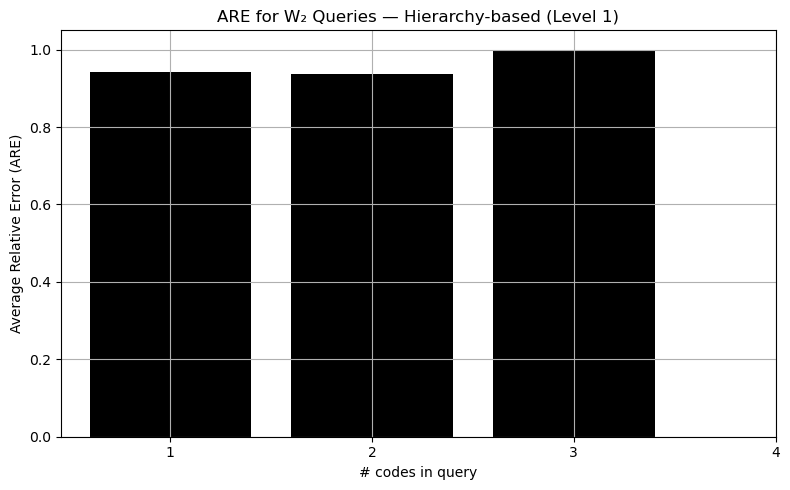

In [37]:
# --- Plot ---
plt.figure(figsize=(8, 5))
x_vals = sorted(results.keys())
y_vals = [np.mean(results[size]) for size in x_vals]
plt.bar(x_vals, y_vals, color="black")
plt.xticks(x_vals)
plt.xlabel("# codes in query")
plt.ylabel("Average Relative Error (ARE)")
plt.title("ARE for W₂ Queries — Hierarchy-based (Level 1)")
plt.grid(True)
plt.tight_layout()
plt.show()

**What Plot Shows**

- X-axis (# codes in query): This indicates the size of each query group (e.g. 1, 2, 3 codes queried together).
- Y-axis (Average Relative Error (ARE)): This is the average of the relative error across all randomly sampled queries of that size.
  - ARE ≈ 0 means high utility (estimated count is close to true count).
  - ARE ≈ 1 means high error (big discrepancy between estimated and true count).

**What Plot Means**

- ARE values very close to 1.0 for all query sizes.
- This suggests that the disassociated data are highly imprecise in answering W₂ queries — likely because:
  - Many shared chunks contain partial information or
  - You’re missing co-occurrence signals due to disassociation (especially without refinement).
  - The slight drop in ARE for size 1–2 indicates better accuracy for small queries, which is expected (fewer combinations = less uncertainty).
  - The jump at size 3 suggests that as query size increases, the likelihood of all codes co-occurring in a single record decreases sharply, but upper bounds still assume possible matches → thus overestimation increases.

**Possible Explanations**

No refinement yet: Only raw disassociation (without the optional REFINE step), so uncertainty is high.

Loose query upper bounds: The check if any(code in shared for code in query) increases upper, possibly inflating estimated count.

Many true counts are small: When true_count is small (e.g. 1–2), even small absolute errors lead to ARE near 1.

# Effectiveness in medical analytic tasks